In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt


In [13]:
# -------------------------------------------------------------------------------------
#   Tensor
# similar to NumPy's ndarrays but can run on GPUs or other hardware accelerators
# we can still use many of the standard numpy matrix operations and functions (*, @, \, .T, ...)
# optimized for automatic differentiation
x = np.arange(10)
x_t = torch.tensor(x, dtype=torch.float64)
W = torch.randn((10, 10), dtype=torch.float64)

# print(W[0, :])
# print('Shape of W: ', W.shape)
# exit(1)

In [6]:
# -------------------------------------------------------------------------------------
#   Autograd
# automatic differentiation provides an efficient way to compute gradients
# each function has forward & backward pass
# the forward is the standard computation, whereas the backward computes partial derivatives
x_t.requires_grad = True
y = (x_t ** 3).sum()
y.backward()

# print(y)
# print(x_t.grad)
# exit(1)

In [14]:
# -------------------------------------------------------------------------------------
#   Transform
# https://pytorch.org/vision/stable/transforms.html
# Can be used for data augmentation - crop/rotate/add noise/...
# ToTensor() -> Convert a PIL Image or numpy.ndarray to tensor in range [0, 1]
# Compose(...) -> Composes several transforms together
# Normalize(mean, std) -> image = (image - mean) / std

# FIXME shift and scale (normalize) each pixel of the input images into the range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(-1, 2)])

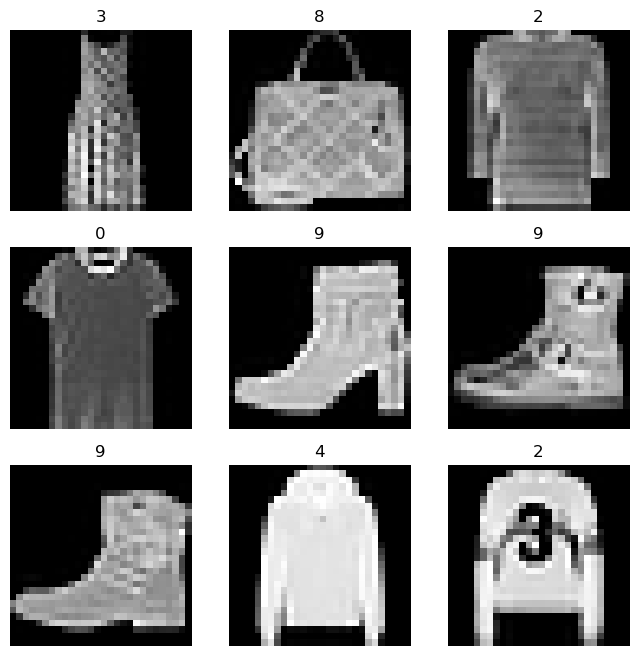

In [15]:
# -------------------------------------------------------------------------------------
#   torchvision.datasets
# Download data from open datasets: https://pytorch.org/vision/stable/datasets.html
# 4 parameters: root - the path where the train/test data is stored,
#               train - specifies, whether the data is used for training or testing
#               download - True/False, download=True to download the data if it's not at root
#               transform - applies the defined transformation on the downloaded data

# FIXME download FashionMNIST dataset instead of MNIST
training_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

# visualize the data
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

# plt.show()
# exit(1)

In [16]:
# -------------------------------------------------------------------------------------
# Create data loaders
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
# exit(1)

# if cuda available:
device = "cuda" if torch.cuda.is_available() else "cpu"

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [65]:
# -------------------------------------------------------------------------------------
#       Defining a model
#   https://pytorch.org/docs/stable/nn.html
#   nn.Linear() - fully-connected layer (default with bias)
#   nn.Flatten() - flattens the 2d input
#   Activation functions: nn.ReLU, nn.GELU, nn.Sigmoid, nn.Tanh, nn.Softmax


# FIXME define the network architecture (self.layers) so that it contains at least 3 weight matrices and 2 different
#  activation functions. As the last activation function, choose the one which is the most suitable for the task of
#  classification. Before blindly designing a network, read the corresponding documentations!
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()   # FIXME
        self.layers = nn.Sequential(
            nn.Linear(28**2, 128), 
            nn.ReLU(),
            nn.Linear(128, 64), 
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits


model = NeuralNetwork().to(device)
# print(model)
# exit(1)

In [66]:
# -------------------------------------------------------------------------------------
#           Defining the loss:
#       https://pytorch.org/docs/stable/nn.html#loss-functions
#   nn.MSELoss:
#       https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss
#   nn.CrossEntropyLoss:
#       https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
#   nn.NLLLoss:
#       https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss

#   FIXME correctly define the loss function according to the function on the output layer
loss_fn = nn.NLLLoss()

In [67]:
# -------------------------------------------------------------------------------------
#       Optimizers  (https://pytorch.org/docs/stable/optim.html)
#   optimizer = torch.optim.SGD(model.parameters())
#   optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# FIXME: specify the model optimizer, its learning rate or if needed, set another additional parameters
optimizer =  torch.optim.Adam(model.parameters(), lr=0.003)


#       Training & Testing the model
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)     # does not require one-hot encoding of y!

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [68]:
# FIXME: Train the network for 5 epochs (in each epoch also print the test error)
for i in range(5):
    train(train_dataloader, model, loss_fn, optimizer)

loss: 2.301494  [    0/60000]
loss: 1.047385  [ 6400/60000]
loss: 0.810975  [12800/60000]
loss: 0.946667  [19200/60000]
loss: 0.999719  [25600/60000]
loss: 0.558954  [32000/60000]
loss: 0.662681  [38400/60000]
loss: 0.542055  [44800/60000]
loss: 0.708235  [51200/60000]
loss: 0.742456  [57600/60000]
loss: 0.659636  [    0/60000]
loss: 0.568795  [ 6400/60000]
loss: 0.768649  [12800/60000]
loss: 0.779152  [19200/60000]
loss: 0.514925  [25600/60000]
loss: 0.711858  [32000/60000]
loss: 0.714671  [38400/60000]
loss: 0.474844  [44800/60000]
loss: 0.639097  [51200/60000]
loss: 0.568346  [57600/60000]
loss: 0.651156  [    0/60000]
loss: 0.423071  [ 6400/60000]
loss: 0.484344  [12800/60000]
loss: 0.357514  [19200/60000]
loss: 0.600417  [25600/60000]
loss: 0.739883  [32000/60000]
loss: 0.674916  [38400/60000]
loss: 0.513650  [44800/60000]
loss: 0.678987  [51200/60000]
loss: 0.389583  [57600/60000]
loss: 0.460384  [    0/60000]
loss: 0.483803  [ 6400/60000]
loss: 0.577067  [12800/60000]
loss: 0.52

In [69]:
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 82.2%, Avg loss: 0.503836 

